# Project : Book Recommendation dengan menggunakan Metode Collaborative Filtering

Nama: : Masahiro Gerarudo Yamazaki<br>
Email: : masahiroymzk24@gmail.com<br>
ID Dicoding: : masayama<br>

# Import Library

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.2 MB/s eta 0:00:00


Pengimporan pustaka yang relevan untuk mendukung pemrosesan data hingga pengembangan model.

In [2]:
from google.colab import files
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import optuna

### Menyiapkan Kredensial Kaggle

Dalam proyek ini, dataset diperoleh dari platform Kaggle. Untuk dapat mengunduh dataset secara langsung melalui API Kaggle, diperlukan kredensial berupa file JSON yang dapat diunduh dari halaman profil akun Kaggle (menu: My Account > Your Profile > Settings > Account > API > Create New API Token). File tersebut kemudian diunggah ke lingkungan kerja sebelum proses pengunduhan dapat dilakukan.

Selain metode pengunduhan langsung dari Kaggle menggunakan API, terdapat beberapa alternatif untuk memuat dataset, antara lain:

1. Mengunduh manual melalui situs Kaggle, lalu mengunggah file secara manual ke lingkungan kerja seperti Google Colab atau Jupyter Notebook.

2. Menggunakan Google Drive, dengan menyimpan dataset hasil unduhan ke Google Drive dan mengaksesnya melalui integrasi Google Drive di Colab.

3. Memanfaatkan cloud storage lain seperti Dropbox atau AWS S3, jika dataset disimpan di sana.

4. Menggunakan dataset lokal, apabila proyek dijalankan di mesin lokal dan file dataset sudah tersedia di direktori lokal.

Pemilihan metode tergantung pada preferensi pengguna serta keterbatasan platform yang digunakan dalam eksperimen.

In [3]:
# Upload kaggle.json

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(
      name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [4]:
# Ubah permission file
!chmod 600 /content/kaggle.json

In [5]:
# Setup Kaggle environment
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

### Mengunduh Dataset

Sumber dataset : [Book Recommendation Dataset]('https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset')

setelah melakukan import library dan menyiapkan API Token pada kaggle yang dibutuhkan untuk project ini, kita sudah bisa melakukan load data dari kaggle

Informasi Terkait Dataset:

Jenis | Keterangan
--- | ---
Title | Book Recommendation Dataset
Source | [Kaggle](https://www.kaggle.com/arashnic/book-recommendation-dataset)
Maintainer | [Möbius](https://www.kaggle.com/arashnic)
License | [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)
Usability | 10.0

In [6]:
# Download Dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 1.04GB/s]


In [7]:
# melakukan ekstraksi pada file zip
local_zip = 'book-recommendation-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/book-recommendation-dataset/')
zip_ref.close()

In [8]:
# Setelah diekstraksi maka kita bisa langsung menghapus berkas zip yang sudah tidak diperlukan
!rm book-recommendation-dataset.zip

## Data Understanding

Pada Dataset ini terdapat 3 berkas csv diantaranya yaitu Books.csv , Ratings.csv , dan Users.csv

Selanjutnya kita akan melihat informasi dataset dengan bantuan `pandas` dimana ini membantu untuk melihat isi dari masing-masing berkas csv tersebut.

In [9]:
# Load dataset

books = pd.read_csv('book-recommendation-dataset/Books.csv')
ratings = pd.read_csv('book-recommendation-dataset/Ratings.csv')
users = pd.read_csv('book-recommendation-dataset/Users.csv')

/tmp/ipython-input-9-1768399755.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('book-recommendation-dataset/Books.csv')


### Books

Berikut ini adalah isi dari `Books.csv`

In [10]:
books.head(6)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...


In [11]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Dari keluaran di atas dapat diketahui bahwa berkas `Books.csv` memuat data-data buku yang terdiri dari 271360 baris dan memiliki 8 kolom, diantaranya adalah :  

- `ISBN` : berisi kode ISBN dari buku  
- `Book-Title` : berisi judul buku
- `Book-Author` : berisi penulis buku
- `Year-Of-Publication` : tahun terbit buku  
- `Publisher` : penerbit buku  
- `Image-URL-S` : URL menuju gambar buku berukuran kecil
- `Image-URL-M` : URL menuju gambar buku berukuran sedang
- `Image-URL-L` : URL menuju gambar buku berukuran besar

### Ratings

Berikut ini adalah isi dari berkas `Ratings.csv`

In [12]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [13]:
ratings.groupby('Book-Rating').count()

,User-ID,ISBN
Book-Rating,,
0,716109,716109
1,1770,1770
2,2759,2759
3,5996,5996
4,8904,8904
5,50974,50974
6,36924,36924
7,76457,76457
8,103736,103736


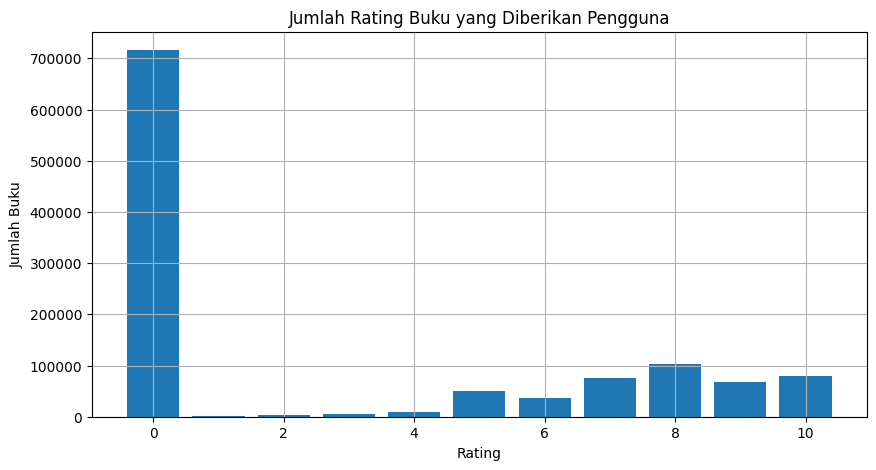

In [14]:
rating_counter = ratings.groupby('Book-Rating').count()
plt.figure(figsize=(10,5))
plt.title('Jumlah Rating Buku yang Diberikan Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.bar(rating_counter.index, rating_counter['ISBN'])
plt.grid(True)
plt.show()

Berdasarkan visualisasi data di atas, terlihat bahwa distribusi data tidak merata dan terdapat banyak pengguna yang memberikan rating dengan nilai 0.

In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [16]:
ratings.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,User-ID,Book-Rating
count,1149780.000000,1149780.000000
mean,140386.395126,2.866950
std,80562.277718,3.854184
min,2.000000,0.000000
25%,70345.000000,0.000000
50%,141010.000000,0.000000
75%,211028.000000,7.000000
max,278854.000000,10.000000


Dari keluaran di atas dapat diketahui bahwa berkas `Ratings.csv` memuat data rating buku yang diberikan oleh pengguna. Data ini memiliki 1149780 baris dan memiliki 3 kolom, yaitu :  
 - `User-ID` : berisi ID unik pengguna
 - `ISBN` : berisi kode ISBN buku yang diberi rating oleh pengguna
 - `Book-Rating` : berisi nilai rating yang diberikan oleh pengguna berkisar antara 0-10

### Users

Berikut ini adalah isi dari `Users.csv`

In [17]:
users.head(6)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0


In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [19]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


Dari keluaran di atas dapat diketahui bahwa berkas `Users.csv` memuat data pengguna. Data ini terdiri dari 278858 baris dan memiliki 3 kolom, yaitu :

- `User-ID` : berisi ID unik pengguna
- `Location` : berisi data lokasi pengguna
- `Age` : berisi data usia pengguna

## Data Preparation

Sebelum dapat ke tahap permodelan, maka data harus melalui tahap data preparation terlebih dahulu karena "Garbage In, Garbage Out" (GIGO) yang artinya kualitas output model sangat tergantung pada kualitas input datanya.

Berikut adalah langkah-langkah yang perlu dilakukan dalam data preparation.

### Handling Imbalanced Data

Karena sebelumnya ditemukan bahwa distribusi rating tidak seimbang, pada tahap ini saya melakukan upaya penanganan dengan menghapus data yang memiliki rating bernilai 0.

In [20]:
ratings.drop(ratings[ratings["Book-Rating"] == 0].index, inplace=True)

Berikut ini adalah jumlah data setelah di-drop

In [21]:
ratings.shape

(433671, 3)

In [22]:
ratings.head(6)

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7


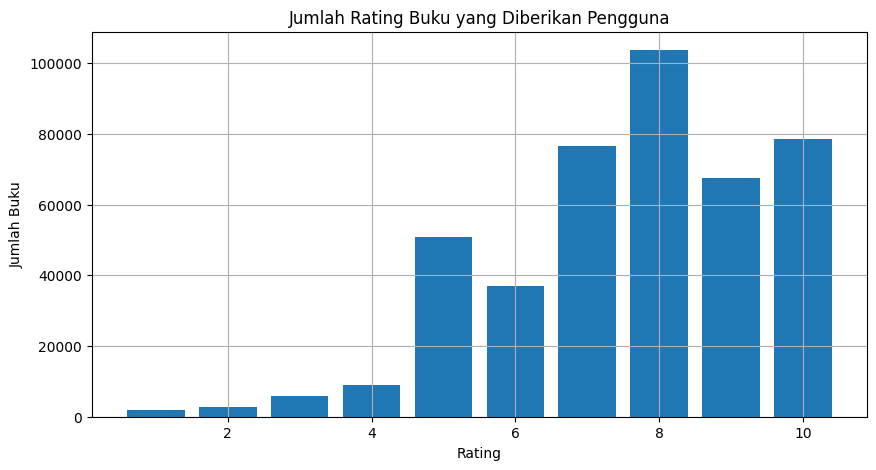

In [23]:
rating_counter = ratings.groupby('Book-Rating').count()
plt.figure(figsize=(10,5))
plt.title('Jumlah Rating Buku yang Diberikan Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.bar(rating_counter.index, rating_counter['ISBN'])
plt.grid(True)
plt.show()

### Encoding Data

Encoding dilakukan untuk menyandikan `User-ID` dan `ISBN` ke dalam indeks integer

In [24]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = ratings['User-ID'].unique().tolist()

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [25]:
# Mengubah ISBN menjadi list tanpa nilai yang sama
isbn_list = ratings['ISBN'].unique().tolist()

# Melakukan encoding ISBN
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_list)}

# Melakukan proses encoding angka ke ISBN
isbn_encoded_to_isbn = {i: x for i, x in enumerate(isbn_list)}

Setelah itu hasil dari encoding akan dimapping ke dataframe `ratings`

In [26]:
# Mapping userID ke dataframe user
ratings['user'] = ratings['User-ID'].map(user_to_user_encoded)

In [27]:
# Mapping userID ke dataframe user
ratings['book'] = ratings['ISBN'].map(isbn_to_isbn_encoded)

In [28]:
ratings.head(6)

,User-ID,ISBN,Book-Rating,user,book
1,276726,0155061224,5,0,0
3,276729,052165615X,3,1,1
4,276729,0521795028,6,1,2
6,276736,3257224281,8,2,3
7,276737,0600570967,6,3,4
8,276744,038550120X,7,4,5


In [29]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
 3   user         433671 non-null  int64 
 4   book         433671 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 19.9+ MB


### Randomize Dataset

Berikut ini adalah proses pengacakan data agar distribusi datanya menjadi random.

In [30]:
# Mengacak dataset
df = ratings.sample(frac=1, random_state=42)
df.head(10)

,User-ID,ISBN,Book-Rating,user,book
144846,32440,0380018179,8,9713,1013
211411,49144,8422641127,5,14390,54663
647520,156424,3442453844,7,44370,127953
30124,7125,0060586125,8,2587,10359
1052982,251606,0316789844,8,70897,7053
99195,22910,3442541751,10,6851,20259
1007724,242006,0373483619,10,68119,170886
74560,16106,0345455207,9,4969,25387
1140618,274301,0855616539,10,77134,13676
783532,189750,8448030494,7,53524,146013


### Data Standardization and Splitting

Setelah proses pengacakan data, dataset kemudian dibagi menjadi dua bagian: 80% digunakan untuk melatih model dan 20% sisanya digunakan untuk proses validasi.

Selain itu, dilakukan juga normalisasi pada nilai rating, yang semula berada dalam rentang 0 hingga 10, diubah menjadi rentang 0 hingga 1 agar proses pelatihan model menjadi lebih efisien dan stabil.

In [31]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_isbn = len(isbn_encoded_to_isbn)
print(num_isbn)

# Mengubah rating menjadi nilai float
df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)

# Nilai minimum Book-Rating
min_rating = min(df['Book-Rating'])

# Nilai maksimal Book-Rating
max_rating = max(df['Book-Rating'])

print('Number of User: {}, Number of ISBN: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_isbn, min_rating, max_rating
))

77805
185973
Number of User: 77805, Number of ISBN: 185973, Min Rating: 1.0, Max Rating: 10.0


In [32]:
# Membuat variabel x untuk mencocokkan data user dan book menjadi satu value
x = df[['user', 'book']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  9713   1013]
 [ 14390  54663]
 [ 44370 127953]
 ...
 [ 22993   6822]
 [ 25753  84887]
 [ 21414  43793]] [0.77777778 0.44444444 0.66666667 ... 0.77777778 0.44444444 0.77777778]


## Modelling
Setelah melalui proses data preparation, maka data sudah siap masuk ke tahap modelling

### Membuat Kelas RecommenderNet

In [33]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_isbn, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_isbn = num_isbn
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.book_embedding = layers.Embedding( # layer embeddings book
        num_isbn,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_isbn, 1) # layer embedding book bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    book_vector = self.book_embedding(inputs[:, 1]) # memanggil layer embedding 3
    book_bias = self.book_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x) # activation sigmoid

### Hyperparameter Tuning

Agar mendapatkan hasil model yang optimal, maka dalam proyek ini menggunakan bantuan library `optuna` untuk melakukan hyperparameter tuning atau pencarian nilai hyperparameter yang terbaik, dalam hal ini adalah nilai `embedding_size`.

In [34]:
def objective(trial):
    tf.keras.backend.clear_session()
    model = RecommenderNet(num_users=num_users, num_isbn=num_isbn, embedding_size=trial.suggest_int('embedding_size', 1, 15))

    # model compile
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    model.fit(
        x = x_train,
        y = y_train,
        batch_size=200,
        epochs = 1,
        validation_data = (x_val, y_val)
    )

    y_pred= model.predict(x_val)

    return np.sqrt(mean_squared_error(y_val, y_pred))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, timeout=500)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-06-24 17:22:53,980] A new study created in memory with name: no-name-fb71b3f1-0dd4-4ebe-8c30-f23568ae7489


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - loss: 0.6652 - root_mean_squared_error: 0.2869 - val_loss: 0.5734 - val_root_mean_squared_error: 0.1974
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


[I 2025-06-24 17:24:23,326] Trial 0 finished with value: 0.25330737585701574 and parameters: {'embedding_size': 9}. Best is trial 0 with value: 0.25330737585701574.


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.6587 - root_mean_squared_error: 0.2813 - val_loss: 0.5733 - val_root_mean_squared_error: 0.1969
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2025-06-24 17:25:52,588] Trial 1 finished with value: 0.2568483081925221 and parameters: {'embedding_size': 13}. Best is trial 0 with value: 0.25330737585701574.


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.6600 - root_mean_squared_error: 0.2824 - val_loss: 0.5736 - val_root_mean_squared_error: 0.1973
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2025-06-24 17:27:21,547] Trial 2 finished with value: 0.2564166747858322 and parameters: {'embedding_size': 13}. Best is trial 0 with value: 0.25330737585701574.


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.6667 - root_mean_squared_error: 0.2887 - val_loss: 0.5727 - val_root_mean_squared_error: 0.1974
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2025-06-24 17:27:49,310] Trial 3 finished with value: 0.25202081955725353 and parameters: {'embedding_size': 2}. Best is trial 3 with value: 0.25202081955725353.


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - loss: 0.6627 - root_mean_squared_error: 0.2846 - val_loss: 0.5735 - val_root_mean_squared_error: 0.1971
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2025-06-24 17:29:18,388] Trial 4 finished with value: 0.25482044822278327 and parameters: {'embedding_size': 12}. Best is trial 3 with value: 0.25202081955725353.


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.6692 - root_mean_squared_error: 0.2907 - val_loss: 0.5735 - val_root_mean_squared_error: 0.1982
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2025-06-24 17:30:06,977] Trial 5 finished with value: 0.2513605255610767 and parameters: {'embedding_size': 2}. Best is trial 5 with value: 0.2513605255610767.


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 70s 39ms/step - loss: 0.6628 - root_mean_squared_error: 0.2851 - val_loss: 0.5735 - val_root_mean_squared_error: 0.1973
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


[I 2025-06-24 17:31:22,359] Trial 6 finished with value: 0.25429655666178796 and parameters: {'embedding_size': 11}. Best is trial 5 with value: 0.2513605255610767.


Number of finished trials: 7
Best trial:
  Value: 0.2513605255610767
  Params: 
    embedding_size: 2


In [35]:
tf.keras.backend.clear_session()

# Menerapkan nilai parameter paling optimal dari optuna
BEST_EMBEDDING_SIZE = 1

model = RecommenderNet(num_users, num_isbn, BEST_EMBEDDING_SIZE)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Melatih Model

In [36]:
# Callback untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan pada val_rmse
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',  # Metrik yang dipantau
    patience=3,                              # Berapa epoch menunggu sebelum berhenti
    restore_best_weights=True,               # Mengembalikan bobot terbaik
    mode='min'                               # Karena kita ingin nilai RMSE serendah mungkin
)

# Memulai training
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/10
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 0.6612 - root_mean_squared_error: 0.2840 - val_loss: 0.5734 - val_root_mean_squared_error: 0.1984
Epoch 2/10
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - loss: 0.5649 - root_mean_squared_error: 0.1894 - val_loss: 0.5660 - val_root_mean_squared_error: 0.1910
Epoch 3/10
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 75s 8ms/step - loss: 0.5532 - root_mean_squared_error: 0.1772 - val_loss: 0.5624 - val_root_mean_squared_error: 0.1875
Epoch 4/10
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.5462 - root_mean_squared_error: 0.1704 - val_loss: 0.5608 - val_root_mean_squared_error: 0.1861
Epoch 5/10
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.5416 - root_mean_squared_error: 0.1647 - val_loss: 0.5599 - val_root_mean_squared_error: 0.1853
Epoch 6/10
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.5374 - root_mean_squared_error: 0.1601 - val_loss: 0.5593 - val_root_mean_squared_error: 0.1848
Epoch 7/10
5421/5421 ━━━━━━━━━━━━━

## Evaluasi

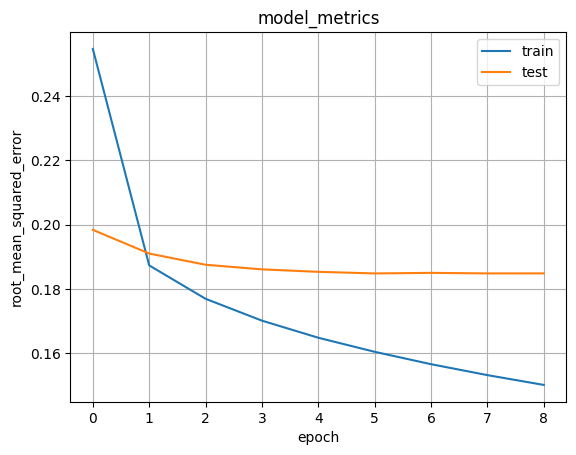

In [37]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

Berdasarkan metrik evaluasi, model yang dikembangkan menghasilkan nilai Root Mean Squared Error (RMSE) sebesar 0.184

## Mendapatkan Rekomendasi

In [38]:
books_df = books
df = pd.read_csv('book-recommendation-dataset/Ratings.csv')

# Mengambil sample user
user_id = df['User-ID'].sample(1).iloc[0]
book_read_by_user = df[df['User-ID'] == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
book_not_read = books_df[~books_df['ISBN'].isin(book_read_by_user.ISBN.values)]['ISBN']
book_not_read = list(
    set(book_not_read)
    .intersection(set(isbn_to_isbn_encoded.keys()))
)

book_not_read = [[isbn_to_isbn_encoded.get(x)] for x in book_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)

In [39]:
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_isbns = [
    isbn_encoded_to_isbn.get(book_not_read[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Books with high ratings from user')
print('----' * 8)

top_book_user = (
    book_read_by_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

book_df_rows = books_df[books_df['ISBN'].isin(top_book_user)]
for row in book_df_rows.itertuples():
    print(row._3, "-", row._2)

print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)

recommended_books = books_df[books_df['ISBN'].isin(recommended_book_isbns)]
for row in recommended_books.itertuples():
    print(row._3, "-", row._2)

4683/4683 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Showing recommendations for users: 177034
Books with high ratings from user
--------------------------------
David Sedaris - Dress Your Family in Corduroy and Denim
Eva Hoffman - Lost in Translation: A Life in a New Language
Neal Stephenson - The Big U
AMY GRAY - Spygirl : True Adventures from My Life as a Private Eye
William Hollingsworth. Whyte - The Last Landscape
--------------------------------
Top 10 book recommendation
--------------------------------
J.R.R. TOLKIEN - The Return of the King (The Lord of the Rings, Part 3)
J. K. Rowling - Harry Potter and the Goblet of Fire (Book 4)
J. K. Rowling - Harry Potter and the Prisoner of Azkaban (Book 3)
J. K. Rowling - Harry Potter and the Sorcerer's Stone (Book 1)
J. R. R. Tolkien - The Two Towers (The Lord of the Rings, Part 2)
Bill Watterson - Calvin and Hobbes
Jodi Picoult - My Sister's Keeper : A Novel (Picoult, Jodi)
Scott Adams - Dilbert: A Book of Postcards
Stephen King - Wolves of the

## Modeling telah selesai, Selanjutnya bisa dilakukan save model apabila ingin di kembangkan ke bentuk aplikasi